# Ross Ice Shelf gravity reduction

# Import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pathlib
import pickle
import seaborn as sns

sns.set_theme()
import os
import string

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [3]:
# from pygmt import session_management

# session_management.end()
# session_management.begin()

# Set region and parameters

In [4]:
# polygon = regions.draw_region()

In [5]:
# starting_region = utils.polygon_to_region(polygon)

In [6]:
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)
# inversion_region, buffer_region = utils.alter_region(
#     starting_region=starting_region,
#     zoom=30e3,
#     # n_shift=0e3,
#     # w_shift=-0e3,
#     buffer=30e3,
# )

# set densities
air_density = 1
ice_density = 915  # +/- 5, from Griggs and Bamber 2009/2011
water_density = 1024  # +/- 5, from Griggs and Bamber 2009/2011
sediment_density = 2300  # will likely change this

# set layer parameters
layer_spacing = 5e3
registration = "g"

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 5e3

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)


# Load data

## topographic layers
* Surface, Icebase, Bed

From notebook `prepare_grids`

In [7]:
# SURFACE
fname = "../inversion_layers/bedmachine_surface.zarr"
# fname= "../inversion_layers/bedmap2_surface.zarr"
surface_full = xr.open_zarr(fname).surface

# ICEBASE
fname = "../inversion_layers/bedmachine_icebase.zarr"
# fname =  "../inversion_layers/bedmap2_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase

# BED
fname = "../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

fname = "../inversion_layers/bedmap2_bed.zarr"
bedmap_bed_full = xr.open_zarr(fname).bed

# starting bed
# fname = "../inversion_layers/bed_from_constraints_verde_spline.zarr"
# fname = "../inversion_layers/bed_from_constraints_gmt_surface.zarr"
# starting_bed_full = xr.open_zarr(fname).bed

fname = "../inversion_layers/RIS_starting_bed_stats.zarr"
starting_bed_full = xr.open_zarr(fname).weighted_mean

# BASEMENT
# Ross Embayment basement merged to bedmachine bed
# basement = "../inversion_layers/bed_basement_merged.zarr"
# Ross Embayment basement merged to ANTASed basement
# basement = "../inversion_layers/ANTASed_magnetics_merged_basement.zarr"
# basement = xr.open_zarr(basement).basement

grids = [
    surface_full,
    icebase_full,
    starting_bed_full,
    bedmap_bed_full,
    bedmachine_bed_full,
]

for g in grids:
    print(utils.get_grid_info(g))

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -66.0, 4345.72607422, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -3347.69384766, 4345.72607422, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3684.76123047, 4054.42285156, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -5162.05029297, 3722.66943359, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -4501.90136719, 4345.72607422, 'g')


### resample to same spacing / region

In [8]:
surface = fetch.resample_grid(
    surface_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
icebase = fetch.resample_grid(
    icebase_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
surface_layer_spacing = fetch.resample_grid(
    surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
starting_bed = fetch.resample_grid(
    starting_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmap_bed = fetch.resample_grid(
    bedmap_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_bed = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# ensure layers never cross
icebase_layer_spacing = xr.where(
    icebase_layer_spacing > surface_layer_spacing,
    surface_layer_spacing,
    icebase_layer_spacing,
)

starting_bed = xr.where(
    starting_bed > icebase_layer_spacing,
    icebase_layer_spacing,
    starting_bed,
)

grids = [
    surface_layer_spacing,
    icebase_layer_spacing,
    starting_bed,
    bedmap_bed,
    bedmachine_bed,
]

for g in grids:
    print(utils.get_grid_info(g))

# set conventional names
# surface = surface.rename({"x": "easting", "y": "northing"})
# icebase = icebase.rename({"x": "easting", "y": "northing"})
# bed = bed.rename({"x": "easting", "y": "northing"})
# bedmachine_bed = bedmachine_bed.rename({"x": "easting", "y": "northing"})
# bedmap_bed = bedmap_bed.rename({"x": "easting", "y": "northing"})

spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -61.0, 4055.69775391, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3020.23144531, 4054.42260742, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3684.76123047, 4054.42260742, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -4043.64941406, 3574.09716797, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3684.76123047, 4054.42260742, 'g')


## bed constraints
from notebook `RIS_bathymetry_data.ipynb`

In [9]:
constraints_fname = "../data/bed_constraints.csv.gz"

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints,
    # buffer_region,
    inversion_region,
    names=("easting", "northing"),
)

print(f"bathymetry control points:{len(constraints)}")
constraints  # .describe()

bathymetry control points:21404


,northing,easting,upward,inside,z_error,weights
1744,-1.420000e+06,-580000.000000,-3480.746338,False,10.000000,0.010000
1745,-1.420000e+06,-575000.000000,-3485.428467,False,10.000000,0.010000
1746,-1.420000e+06,-570000.000000,-3478.754395,False,10.000000,0.010000
1747,-1.420000e+06,-565000.000000,-3474.058594,False,10.000000,0.010000
1748,-1.420000e+06,-560000.000000,-3444.888428,False,10.000000,0.010000
...,...,...,...,...,...,...
28082,-1.206553e+06,206601.786491,-731.829528,True,35.822378,0.000779
28083,-1.200263e+06,-316755.706913,-521.706527,True,24.728047,0.001635
28084,-1.092887e+06,326582.733297,-885.094801,True,44.006194,0.000516
28085,-1.196613e+06,-404256.274102,-651.903650,True,31.641187,0.000999


## Load gravity disturbance data

github repository [RIS_grav_bath_data](https://github.com/mdtanker/RIS_grav_bath_data), contains a compilation of gravity data and bed elevation constraints for the Ross Ice Shelf region. Load the data into a pandas dataframe with the below cell. 

> **Note:** this repo is currently private, so it requires a github authentication token!

In [10]:
# load gravity data
grav = pd.read_csv(
    "../data/rosetta_eq_source_1k_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav

,northing,easting,test,upward,Gobs,inside
0,-1365000.0,147500.0,True,1000.0,-21.437198,True
1,-1365000.0,150000.0,False,1000.0,-22.503368,True
2,-1365000.0,152500.0,True,1000.0,-23.521033,True
3,-1365000.0,155000.0,False,1000.0,-24.474428,True
4,-1365000.0,157500.0,True,1000.0,-25.353009,True
...,...,...,...,...,...,...
86032,-427500.0,-262500.0,True,1000.0,-52.962891,True
86033,-427500.0,-260000.0,True,1000.0,-54.814527,True
86034,-427500.0,-257500.0,True,1000.0,-56.674146,True
86035,-425000.0,-265000.0,False,1000.0,-50.846823,True


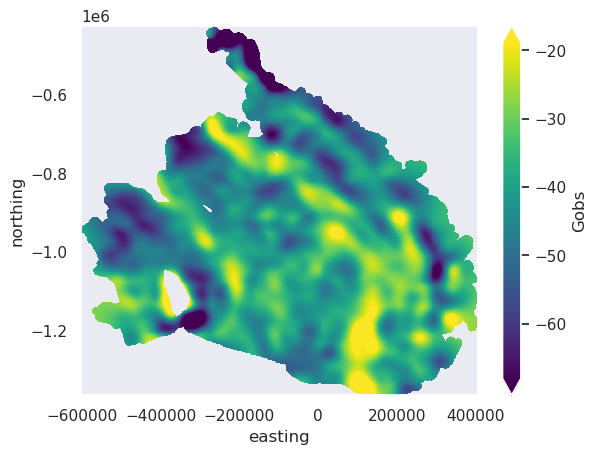

In [11]:
grav.set_index(["northing", "easting"]).to_xarray().Gobs.plot(robust=True)

In [12]:
# grav_grid = inv_utils.filter_grid(
#     grav_grid_full.Gobs,
#     50e3,
#     filt_type="lowpass",
# )

# grav_grid = grav_grid_full.Gobs

# print(utils.get_grid_info(grav_grid))

# grav_grid.plot()

In [13]:
# grav = vd.grid_to_table(grav_grid_full)
# grav = grav[grav.Gobs.notna()]
# # grav["upward"] = 1000
# grav.describe()

In [14]:
grav_df = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)
grav_df.head()

,northing,easting,test,upward,Gobs,inside
0,-1365000.0,147500.0,True,1000.0,-21.437198,True
1,-1365000.0,150000.0,False,1000.0,-22.503368,True
2,-1365000.0,152500.0,True,1000.0,-23.521033,True
3,-1365000.0,155000.0,False,1000.0,-24.474428,True
4,-1365000.0,157500.0,True,1000.0,-25.353009,True


# Topo-free gravity disturbance

Start by filling everything above ellipsoid with ice, and everything below with water. Then correct the remaining anomalous masses relative to ice if above ellipsoid, or relative to water if below ellipsoid.

In [24]:
ice_surface_prisms = inv_utils.grids_to_prisms(
    surface=surface_layer_spacing,
    reference=0,
    density=xr.where(
        surface_layer_spacing >= 0,
        ice_density - air_density,
        air_density - ice_density,
    ),
)

water_surface_prisms = inv_utils.grids_to_prisms(
    surface=icebase_layer_spacing,
    reference=0,
    density=xr.where(
        icebase_layer_spacing >= 0,
        water_density - ice_density,
        ice_density - water_density,
    ),
)

starting_bed_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=0,
    density=xr.where(
        starting_bed >= 0,
        sediment_density - water_density,
        water_density - sediment_density,
    ),
)

# save starting bed prisms to zarr to use in inversion
enc = {x: {"compressor": zarr.Blosc()} for x in starting_bed_prisms}
starting_bed_prisms.to_zarr(
    "../inversion_layers/RIS_starting_bed_prisms_mean.zarr",
    # "../inversion_layers/RIS_starting_bed_prisms_verde_spline.zarr",
    # "../inversion_layers/RIS_starting_bed_prisms_gmt_surface.zarr",
    encoding=enc,
    mode="w",
)

Number of ice surface prisms: 47089
Number of water surface prisms: 47089
Number of bed prisms: 47089


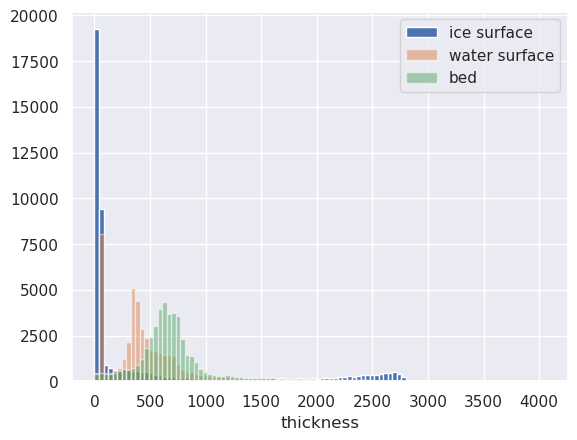

In [25]:
_ = ice_surface_prisms.thickness.plot.hist(bins=100, label="ice surface")
_ = water_surface_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="water surface")
_ = starting_bed_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="bed")


print(
    f"Number of ice surface prisms:",
    len(
        ice_surface_prisms.thickness.values[
            ~np.isnan(ice_surface_prisms.thickness.values)
        ]
    ),
)
print(
    f"Number of water surface prisms:",
    len(
        water_surface_prisms.thickness.values[
            ~np.isnan(water_surface_prisms.thickness.values)
        ]
    ),
)
print(
    f"Number of bed prisms:",
    len(
        starting_bed_prisms.thickness.values[
            ~np.isnan(starting_bed_prisms.thickness.values)
        ]
    ),
)

plt.legend()

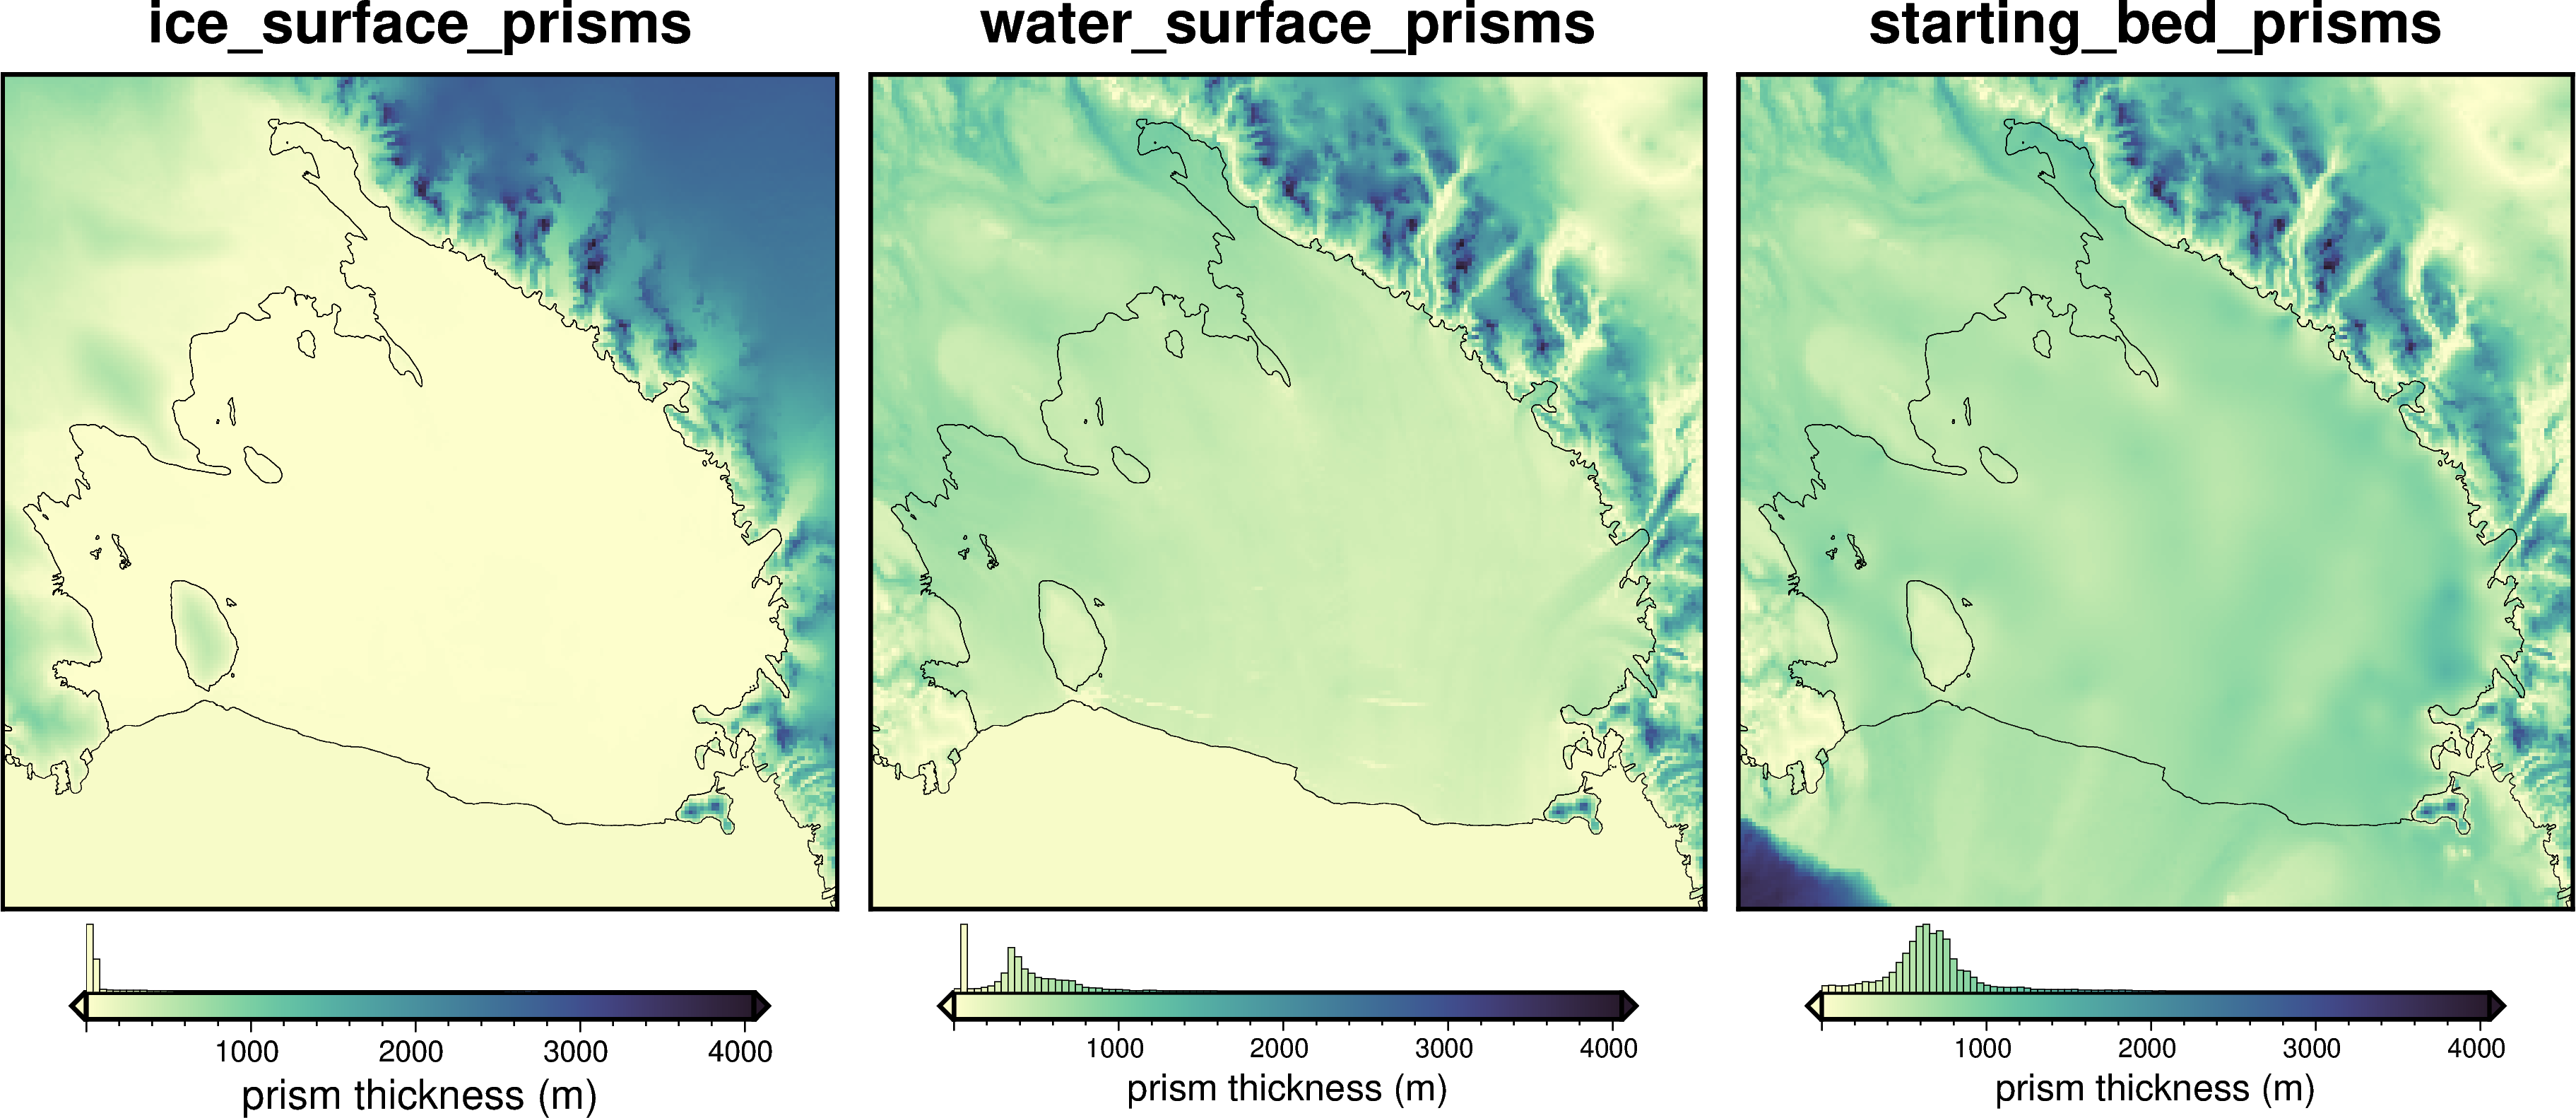

In [14]:
fig = maps.plot_grd(
    ice_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="ice_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
)

fig = maps.plot_grd(
    water_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="water_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    starting_bed_prisms.thickness,
    coast=True,
    coast_pen="0.2p,black",
    title="starting_bed_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Calculate gravity

In [26]:
# calculate gravity of prisms
forward_grid, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        ice_surface_prisms,
        water_surface_prisms,
        starting_bed_prisms,
    ],
    grav_df,
    names=[
        "ice_surface_prisms",
        "water_surface_prisms",
        "starting_bed_prisms",
    ],
    # thickness_threshold=1,
    progressbar=True,
    plot=False,
)

grav_df["ice_surface_grav"] = forward_df.ice_surface_prisms
grav_df["water_surface_grav"] = forward_df.water_surface_prisms
grav_df["starting_bed_grav"] = forward_df.starting_bed_prisms

grav_df.describe()

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677


## Correct the observed gravity

In [27]:
# grav_df["terrain_effect"] = (
#     grav_df.ice_surface_grav + grav_df.water_surface_grav + grav_df.starting_bed_grav
# )
# grav_df["topo_corrected_disturbance"] = grav_df.Gobs - grav_df.terrain_effect

grav_df["partial_topo_corrected_disturbance"] = (
    grav_df.Gobs - grav_df.ice_surface_grav - grav_df.water_surface_grav
)

grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789


## Calculate misfit (partial topo-corrected disturance - starting bed grav)  

In [28]:
# grav_df = inv.misfit(
#     input_grav=grav_df,
#     input_forward_column="starting_bed_grav",
#     input_grav_column="partial_topo_corrected_disturbance",
#     constraints=constraints,
# )
# grav_df.drop(columns=["partial_topo_corrected_disturbance_shift"], inplace=True)
grav_df["misfit"] = (
    grav_df.partial_topo_corrected_disturbance - grav_df.starting_bed_grav
)
grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787


## Save and load results

In [29]:
grav_df.to_csv(
    "../data/RIS_topo_corrections_mean_bed.csv.gz",
    # "../data/RIS_topo_corrections_verde_spline_levelled.csv.gz",
    # "../data/RIS_topo_corrections_gmt_surface_levelled.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [30]:
grav_df = pd.read_csv(
    "../data/RIS_topo_corrections_mean_bed.csv.gz",
    # "../data/RIS_topo_corrections_verde_spline_levelled.csv.gz",
    # "../data/RIS_topo_corrections_gmt_surface_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787


# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field.  

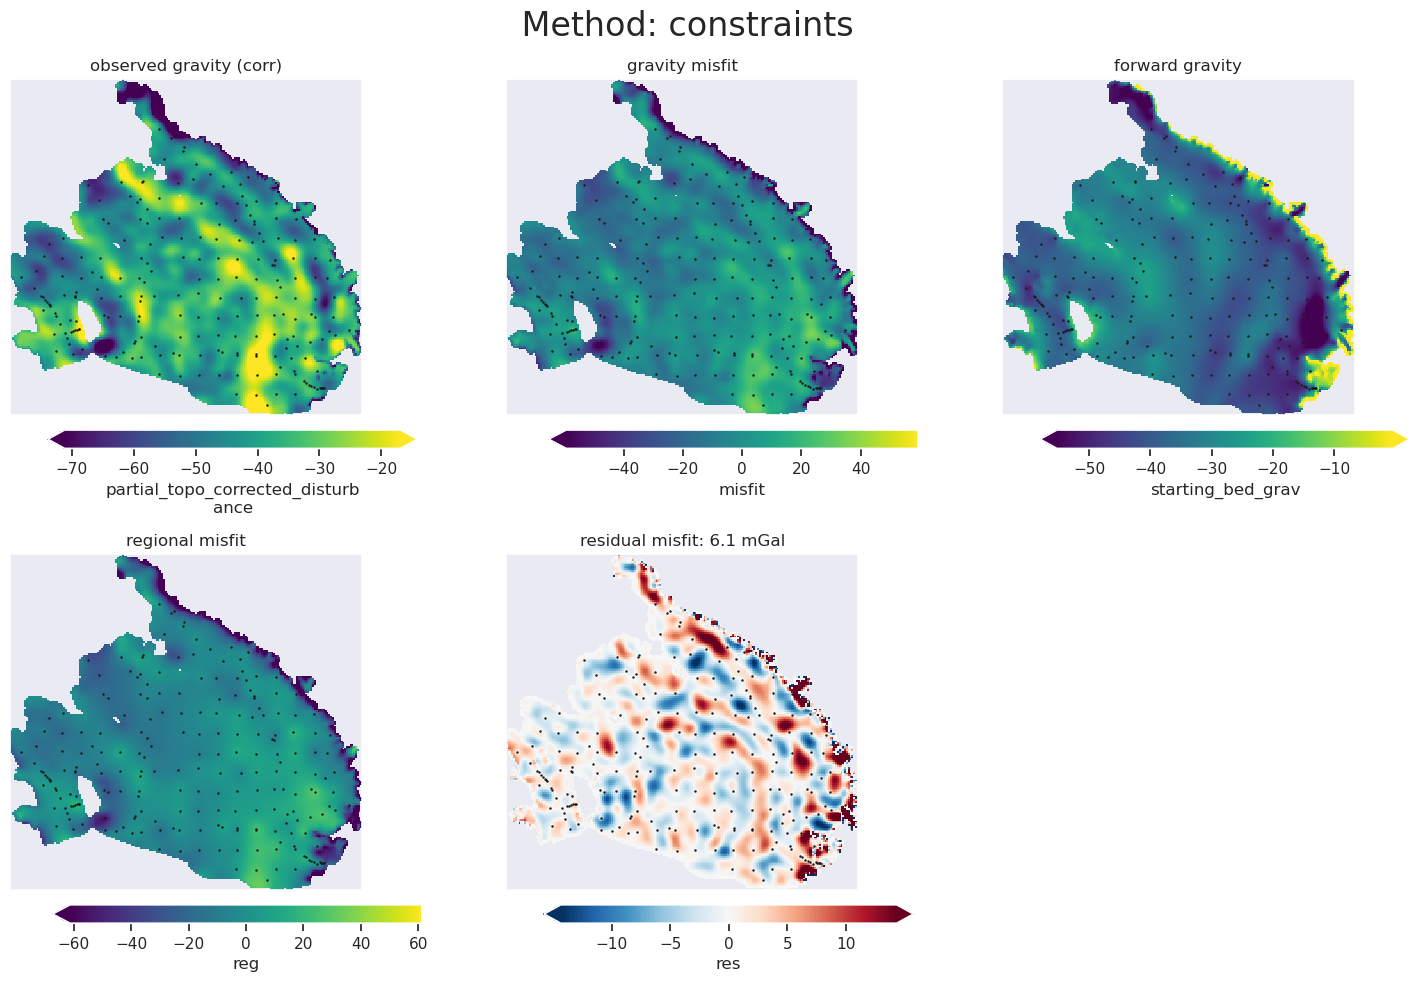

In [36]:
regional_kwargs = dict(
    input_grav=grav_df,
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    constraints=constraints,
    # grid_method="verde",
    # dampings=np.logspace(-50, 0, num=3),
    dampings=10**-20,
    # delayed=True,
    grid_method="pygmt",
    tension_factor=0.25,
    # grid_method="eq_sources",
    # eqs_gridding_damping_lims = [1, 10],
    # eqs_gridding_depth_lims = [1e3, 50e3],
    # eqs_gridding_trials = 6,
    constraint_block_size=layer_spacing,
    # constraint_weights_col="weights",
    # block_size= grav_spacing,
    regional_method="constraints",
    # regional_method = "trend",
    # trend=10,
    # regional_method = "eq_sources",
    # eq_sources = 500e3,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
    df_anomalies = regional.regional_seperation(
        **regional_kwargs,
    )

anom_grids = plotting.anomalies_plotting(
    df_anomalies[df_anomalies.test == False],
    title=f" Method: {regional_kwargs.get('regional_method')}",
    input_forward_column="starting_bed_grav",
    input_grav_column="partial_topo_corrected_disturbance",
    plot_type="xarray",
    constraints=constraints[
        constraints.inside
    ],  # .rename(columns={"easting":"x","northing":"y"}),
    constraint_size=1.5,
    # plot_type="pygmt",
    # constraints=constraints[constraints.inside].rename(columns={"easting":"x","northing":"y"}),
    # robust=False,
)  # .94

In [32]:
df_anomalies.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492,-6.007341,0.409849
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138,17.471707,5.865073
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796,-143.524001,-53.431386
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437,-11.360050,-2.159865
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370,-3.799498,0.004364
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478,3.291219,2.218660
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787,36.448793,82.099716


### Save and load results

In [37]:
df_anomalies.to_csv(
    "../data/RIS_topo_corrections_levelled_mean_bed.csv.gz",
    # "../data/RIS_topo_corrections_levelled_verde_spline.csv.gz",
    # "../data/RIS_topo_corrections_levelled_gmt_surface.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [21]:
df_anomalies = pd.read_csv(
    "../data/RIS_topo_corrections_levelled_mean_bed.csv.gz",
    # "../data/RIS_topo_corrections_levelled_verde_spline.csv.gz",
    # "../data/RIS_topo_corrections_levelled_gmt_surface.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

df_anomalies

,northing,easting,test,upward,Gobs,inside,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res
0,-1365000.0,147500.0,True,1000.0,-21.437198,True,-2.032417,-0.271613,-40.685208,-19.133169,21.552039,21.972942,-0.420903
1,-1365000.0,150000.0,False,1000.0,-22.503368,True,-2.031799,-0.272119,-40.819507,-20.199450,20.620057,20.758575,-0.138518
2,-1365000.0,152500.0,True,1000.0,-23.521033,True,-2.031245,-0.272546,-40.782656,-21.217241,19.565415,19.552794,0.012621
3,-1365000.0,155000.0,False,1000.0,-24.474428,True,-2.030761,-0.272887,-40.678516,-22.170780,18.507737,18.369875,0.137862
4,-1365000.0,157500.0,True,1000.0,-25.353009,True,-2.030344,-0.273143,-40.457919,-23.049522,17.408397,17.238495,0.169902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85909,-427500.0,-262500.0,True,1000.0,-52.962891,True,6.301771,-2.854282,-33.516579,-56.410379,-22.893800,-21.887625,-1.006175
85910,-427500.0,-260000.0,True,1000.0,-54.814527,True,7.205060,-2.832430,-33.260550,-59.187157,-25.926607,-24.828747,-1.097860
85911,-427500.0,-257500.0,True,1000.0,-56.674146,True,8.138428,-2.768166,-32.508235,-62.044408,-29.536173,-28.721795,-0.814378
85912,-425000.0,-265000.0,False,1000.0,-50.846823,True,6.105235,-2.078981,-24.415316,-54.873077,-30.457762,-23.821194,-6.636568


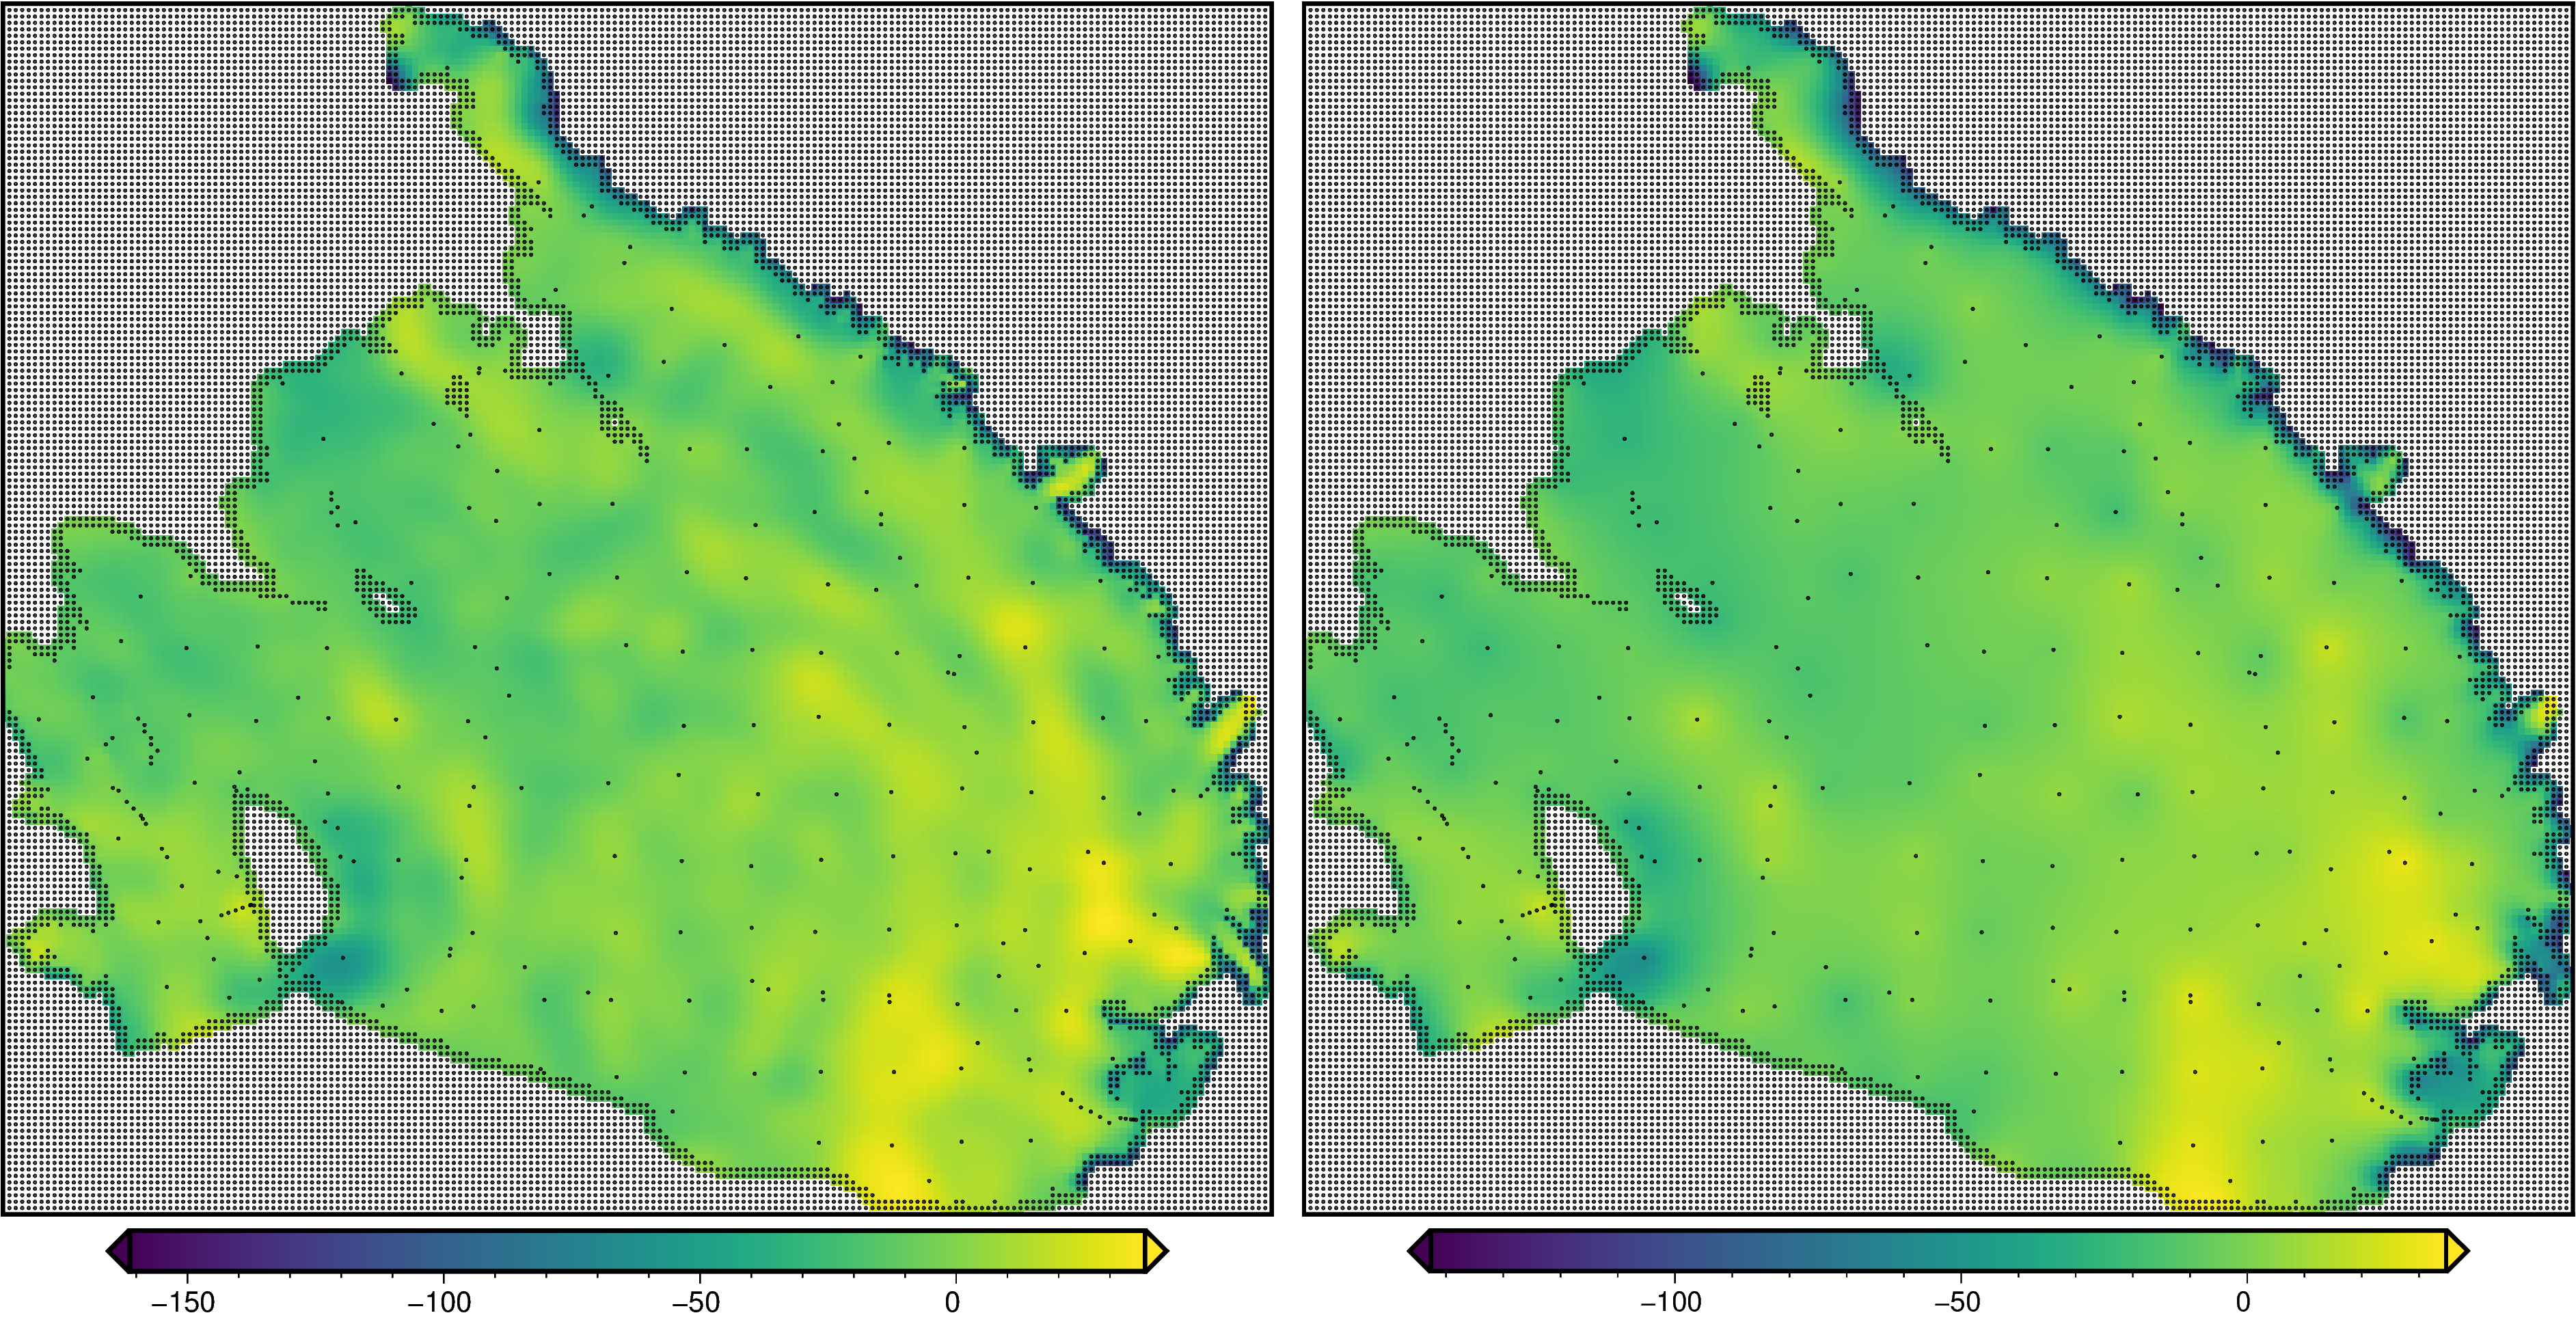

In [39]:
g = df_anomalies[~df_anomalies.test].set_index(["northing", "easting"]).to_xarray()
fig = maps.plot_grd(
    g.misfit,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.01c",
    # cpt_lims=[],
)
fig = maps.plot_grd(
    g.reg,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.01c",
    fig=fig,
    origin_shift="xshift",
)
fig.show()

# Plots

In [ ]:
# lines = profile.draw_lines()

In [ ]:
# # get clicked points
# # df = utils.shapes_to_df(lines)
# # # extract first and last
# # a = (df.x.iloc[0], df.y.iloc[0])
# # b = (df.x.iloc[-1], df.y.iloc[-1])

# # # siple coast
# # a, b = ((-514139.22589550324, -886012.3396426054),
# # (-30871.591933855758, -595196.2984418197))

# # # ice front to CIR
# # a,b = ((48403.646330947464, -1387918.0291082778),
# #  (-221877.26567443524, -613795.4844574957))

# # # Roosevelt Island to TAM
# # a,b = ((-489471.998996549, -1177190.3876565588),
# #  (190464.00058142765, -777830.3659641005))

# # # KIS to Ross Island
# # a,b = ((-391311.08538905036, -713591.4759308188),
# # (288280.6584588745, -1311607.5333427137))

# # South of Roosevelt to TAM
# a,b = ((-571375.4234697601, -1051511.5422168665),
#  (132779.8923736067, -719735.4502564461))
# a,b

In [ ]:
# grav_grids = df_anomalies[df_anomalies.test == False].set_index(["northing", "easting"]).to_xarray()

# # extract layers for profile plot
# topo_grids = [
#     surface,
#     icebase,
#     starting_bed,
# ]
# topo_names = [
#     "ice surface",
#     "ice base",
#     "bed",
# ]

# data_grids = [
#     # grav_grids.ice_surface_grav + grav_grids.water_surface_grav,
#     grav_grids.misfit,
#     grav_grids.reg,
#     grav_grids.res,
#     # starting_bed_prisms.weights
# ]

# data_names = [
#     # "Ice and Water effects",
#     "Topo-corrected disturbance",
#     "Regional",
#     "Residual",
#     # "Weighting grid",
# ]

# layers_dict = profile.make_data_dict(
#     names=topo_names,
#     grids=topo_grids,
#     colors=["lightskyblue", "darkblue", "lightbrown"],
# )

# data_dict = profile.make_data_dict(
#     names=data_names,
#     grids=data_grids,
#     colors=[
#         # "cyan",
#         "red",
#         "black",
#         "blue",
#         # "purple",
#     ],
#     axes = [0,0,0,1],
# )

In [ ]:
# fig = profile.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     # add_map=True,
#     map_buffer=0.2,
#     subplot_orientation="horizontal",
#     # subplot_orientation='vertical',
#     data_dict=data_dict,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     data_height=5,
# )
# fig.show()

In [ ]:
# grav_grids = (
#     df_anomalies[df_anomalies.test == False].set_index(["northing", "easting"]).to_xarray()
# )

# grids = [
#     grav_grids.misfit,
#     grav_grids.reg,
#     grav_grids.res,
# ]

# titles = [
#     "Topo-corrected disturbance",
#     "Regional",
#     "Residual",

# ]

# # lims = [utils.get_min_max(i, robust=True) for i in grids]
# # lims = [min([i for i in lims[0]]), max([i for i in lims[1]])]
# # lims = utils.get_min_max(grids[2])

# for i, g in enumerate(grids):
#     if i == 0:
#         fig = None
#         origin_shift = "initialize"
#         xshift_amount = 1
#     else:
#         fig = fig
#         origin_shift = "xshift"
#         xshift_amount = 1

#     if i == 2:
#         cmap = "balance+h0"
#         robust = False
#     else:
#         cmap = "viridis"
#         robust = True
#     # cmap = "viridis"

#     fig = maps.plot_grd(
#         fetch.modis_moa(),
#         image=True,
#         cmap="gray",
#         region=inversion_region,
#         fig_height=10,
#         transparency=50,
#         fig=fig,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )

#     fig = maps.plot_grd(
#         grid=g,
#         fig_height=10,
#         region=inversion_region,
#         coast=True,
#         coast_type="measures-v2",
#         region=inversion_region,
#         # cmap=f"vik+h{np.nanmedian(g)}",
#         cmap=cmap,
#         robust=robust,
#         title=titles[i],
#         cbar_label="mGal",
#         points=constraints[constraints.inside].rename(
#             columns={"easting": "x", "northing": "y"}
#         ),
#         points_style="x0.05c",
#         hist=True,
#         cbar_yoffset=1,
#         fig=fig,
#         origin_shift="no_shift",
#     )
#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i]})",
#         font="20p,Helvetica,black",
#         offset="j0/.3",
#         no_clip=True,
#     )

#     if i == 1:
#         # plot profile location, and endpoints on map
#         fig.plot(
#             vd.line_coordinates(a, b, size=100),
#             pen="2p,black",
#         )
#         fig.text(
#             x=a[0],
#             y=a[1],
#             text="A",
#             fill="white",
#             font="12p,Helvetica,black",
#             justify="CM",
#             clearance="+tO",
#         )
#         fig.text(
#             x=b[0],
#             y=b[1],
#             text="B",
#             fill="white",
#             font="12p,Helvetica,black",
#             justify="CM",
#             clearance="+tO",
#         )
# fig.show()

# Corrections as contrasts (zref=0)

## Surface prisms

In [ ]:
# # create prisms around surface
# # positive densities above reference, negative below
# density = ice_density - air_density
# print(f"Surface density contrast: {density}kgm-3")

# zref = np.nanmean(surface)
# # zref = 0
# surface_prisms = inv_utils.grids_to_prisms(
#     surface=surface,
#     reference=zref,
#     density=xr.where(surface >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

## Icebase prisms

In [ ]:
# # create prisms around icebase
# # positive densities above reference, negative below
# density = water_density - ice_density
# print(f"Icebase density contrast: {density}kgm-3")

# zref = np.nanmean(icebase)
# # zref = 0
# icebase_prisms = inv_utils.grids_to_prisms(
#     surface=icebase,
#     reference=zref,
#     density=xr.where(icebase >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

## Starting bed prisms

In [ ]:
# # create prisms around bed
# # positive densities above reference, negative below
# density = sediment_density - water_density
# print(f"Bed density contrast: {density}kgm-3")

# zref = np.nanmean(starting_bed)
# # zref = 0
# bed_prisms = inv_utils.grids_to_prisms(
#     surface=starting_bed,
#     reference=zref,
#     density=xr.where(starting_bed >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

In [ ]:
# # calculate forward gravity
# forward_grav_grid, forward_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [surface_prisms, icebase_prisms, bed_prisms],
#     grav_df,
#     names=["surface_prisms", "icebase_prisms", "bed_prisms"],
#     progressbar=True,
#     plot=False,
# )

# grav_df["surface_forward"] = forward_grav_df.surface_prisms
# grav_df["icebase_forward"] = forward_grav_df.icebase_prisms
# grav_df["bed_forward"] = forward_grav_df.bed_prisms

# grav_df.describe()

## Correct the observed gravity

In [ ]:
# grav_df["terrain_effect"] = grav_df.surface_forward + grav_df.icebase_forward

# grav_df["Gobs_corr_contrasts"] = grav_df.Gobs - grav_df.terrain_effect

# grav_df.describe()

## Misfit

In [ ]:
# grav_df = inv.misfit(
#     input_grav=grav_df,
#     input_forward_column="bed_forward",
#     input_grav_column="Gobs_corr_contrasts",
#     constraints=constraints,
# )

# # grav_df["total_misfit"] = grav_df.Gobs_corr - grav_df.bed_forward
# grav_df.describe()

## Save and load results

In [ ]:
# grav_df.to_csv(
#     "../data/RIS_topo_corrections.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [ ]:
# grav_df = pd.read_csv(
#     "../data/RIS_topo_corrections.csv.gz",
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )

# grav_df.describe()

# Stripping masses

In [28]:
ice_prisms = inv_utils.grids_to_prisms(
    surface=surface_layer_spacing,
    reference=icebase_layer_spacing,
    density=ice_density,
)

water_prisms = inv_utils.grids_to_prisms(
    surface=icebase_layer_spacing,
    reference=starting_bed,
    density=water_density,
)

earth_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=np.nanmin(starting_bed),
    density=sediment_density,
)

Number of ice prisms: 47089
Number of water prisms: 47089
Number of earth prisms: 47089


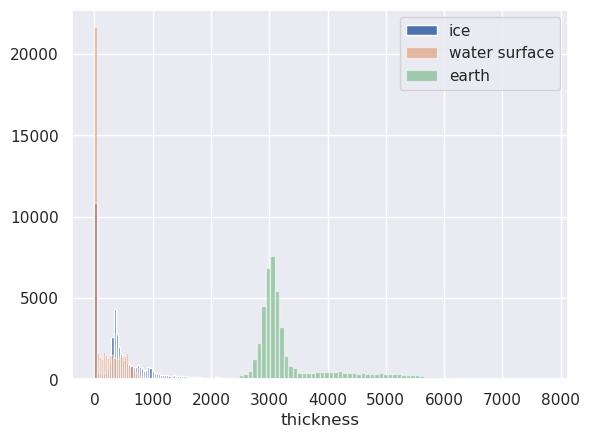

In [29]:
_ = ice_prisms.thickness.plot.hist(bins=100, label="ice")
_ = water_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="water surface")
_ = earth_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="earth")


print(
    f"Number of ice prisms:",
    len(ice_prisms.thickness.values[~np.isnan(ice_prisms.thickness.values)]),
)
print(
    f"Number of water prisms:",
    len(water_prisms.thickness.values[~np.isnan(water_prisms.thickness.values)]),
)
print(
    f"Number of earth prisms:",
    len(earth_prisms.thickness.values[~np.isnan(earth_prisms.thickness.values)]),
)

plt.legend()

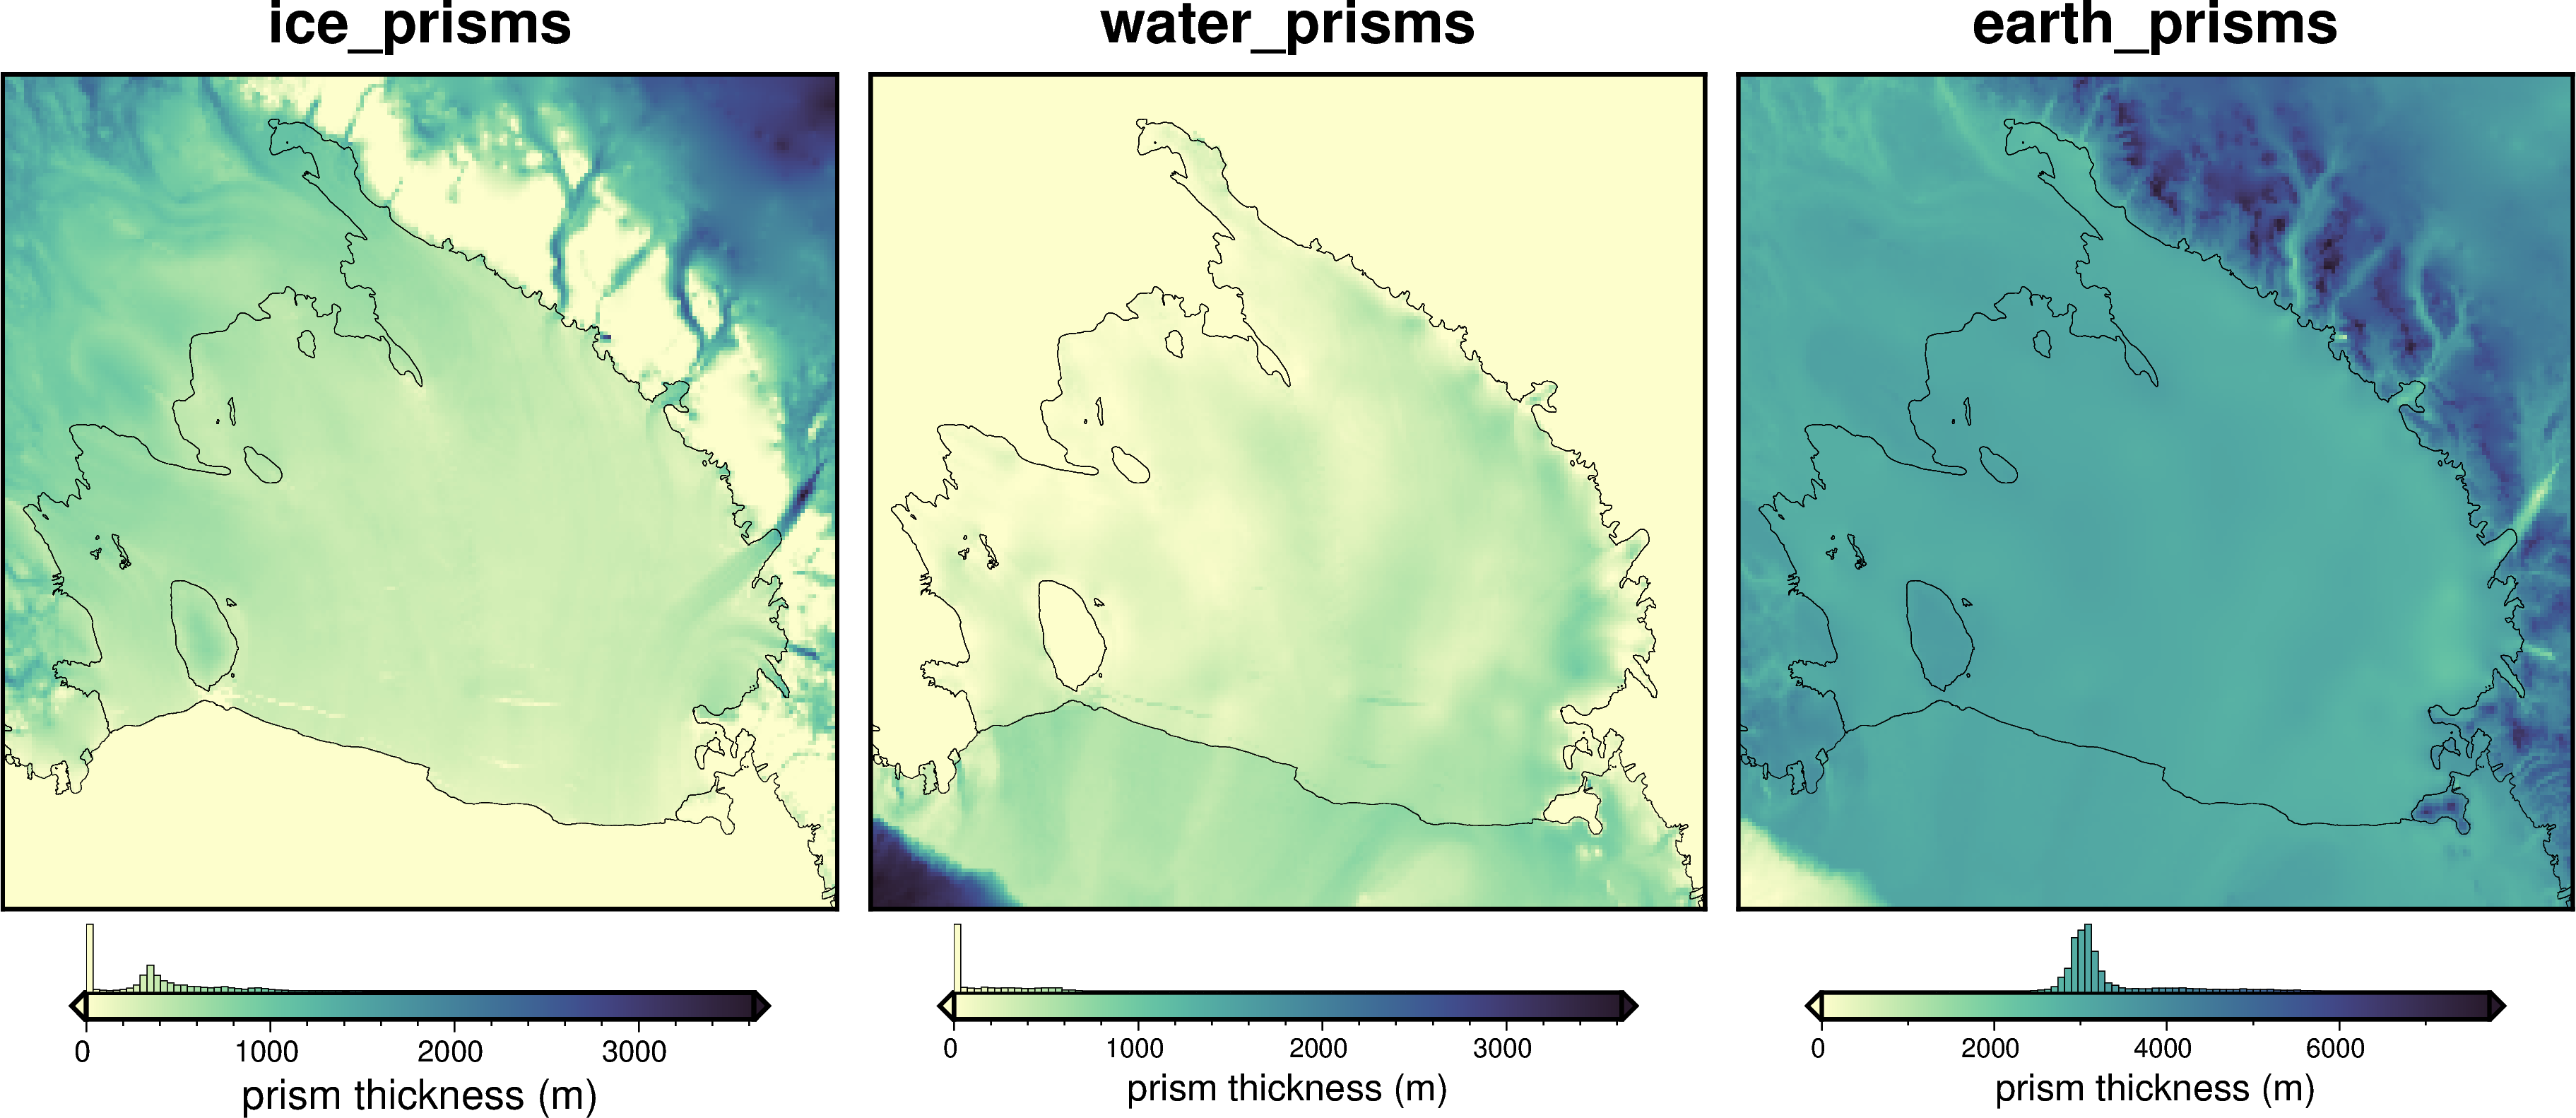

In [30]:
fig = maps.plot_grd(
    ice_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="ice_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
)

fig = maps.plot_grd(
    water_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="water_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    earth_prisms.thickness,
    coast=True,
    coast_pen="0.2p,black",
    title="earth_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Calculate gravity

In [31]:
# calculate gravity of prisms
forward_grid, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        ice_prisms,
        water_prisms,
        earth_prisms,
    ],
    df_anomalies,
    names=[
        "ice_prisms",
        "water_prisms",
        "earth_prisms",
    ],
    # thickness_threshold=1,
    progressbar=True,
    plot=False,
)

df_anomalies["ice_grav"] = forward_df.ice_prisms
df_anomalies["water_grav"] = forward_df.water_prisms
df_anomalies["earth_grav"] = forward_df.earth_prisms

df_anomalies.describe()

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res,ice_grav,water_grav,earth_grav,stripping_effect_as_masses,stripped_disturbance_as_masses,terrain_effect
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85791.000000,85791.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492,-6.007341,0.409849,15.634259,10.754372,290.540912,316.934023,-358.558505,-36.037933
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138,17.471707,5.865073,6.466270,7.894227,20.546438,13.982327,17.947821,14.042317
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796,-143.524001,-53.431386,-5.860135,0.044136,224.104067,279.129731,-513.665554,-73.319443
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437,-11.360050,-2.159865,12.429808,3.763737,280.163095,310.480183,-365.903190,-42.331807
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370,-3.799498,0.004364,14.270318,9.712458,289.321731,315.712301,-357.062841,-37.553567
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478,3.291219,2.218660,18.406435,16.157813,298.196220,320.746025,-348.280154,-32.559759
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787,36.448793,82.099716,64.593578,37.543068,438.734348,440.592255,-314.531529,88.228553


## Correct the observed gravity

In [32]:
df_anomalies["stripping_effect_as_masses"] = (
    df_anomalies.ice_grav + df_anomalies.water_grav + df_anomalies.earth_grav
)

df_anomalies["stripped_disturbance_as_masses"] = (
    df_anomalies.Gobs - df_anomalies.stripping_effect_as_masses
)
df_anomalies.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res,ice_grav,water_grav,earth_grav,stripping_effect_as_masses,stripped_disturbance_as_masses,terrain_effect
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492,-6.007341,0.409849,15.634259,10.754372,290.540912,316.929543,-358.564967,-36.037933
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138,17.471707,5.865073,6.466270,7.894227,20.546438,13.989464,17.924923,14.042317
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796,-143.524001,-53.431386,-5.860135,0.044136,224.104067,279.129731,-520.416073,-73.319443
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437,-11.360050,-2.159865,12.429808,3.763737,280.163095,310.471697,-365.564027,-42.331807
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370,-3.799498,0.004364,14.270318,9.712458,289.321731,315.706891,-356.851614,-37.553567
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478,3.291219,2.218660,18.406435,16.157813,298.196220,320.743823,-348.645349,-32.559759
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787,36.448793,82.099716,64.593578,37.543068,438.734348,440.592255,-314.761282,88.228553


In [33]:
df_anomalies["terrain_effect"] = (
    df_anomalies.ice_surface_grav
    + df_anomalies.water_surface_grav
    + df_anomalies.starting_bed_grav
)

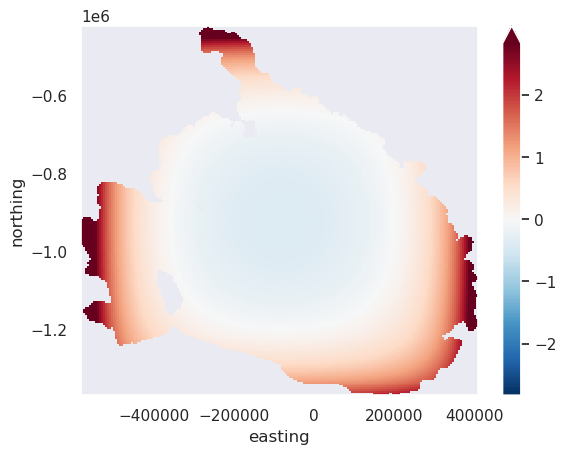

In [35]:
grav_grids = (
    df_anomalies[~df_anomalies.test].set_index(["northing", "easting"]).to_xarray()
)

offset = np.nanmedian(
    (grav_grids.terrain_effect) - grav_grids.stripping_effect_as_masses
)

stripping_centered = grav_grids.stripping_effect_as_masses + offset


dif = grav_grids.terrain_effect - stripping_centered

region = regions.ross_ice_shelf

dif = dif.sel(
    easting=slice(region[0], region[1]),
    northing=slice(region[2], region[3]),
)
dif.plot(robust=True)